Bartosz Rożek 298839

# Laboratorium 3

 Zaimplementować dwa usprawnienia uczenia gradientowego sieci neuronowej:

    moment,
    normalizację gradientu RMSProp.

Porównać szybkość zbieżności procesu uczenia dla obu wariantów.

Przeprowadzić eksperymenty na zbiorach:

    square-large,
    steps-large,
    multimodal-large.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

Matplotlib is building the font cache; this may take a moment.


In [3]:
np.random.seed(420)

In [4]:
def sigmoid(x):
        return 1 / (1 + np.exp(-x))

In [5]:
def sigmoid_der(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Klasa mlp

In [91]:
class MLP:
    """
    layers - wektor zawierający liczbę kolejnych neuronów warstwach, w tym wejscie i wyjscie
    weights_biases - wybor metody losowania wag
    activation_function - funkcja aktywacji
    activation_function_dev - pochodna funkcja aktywacji
    delta_w, delta_b - zmiana biasu i wag w propagacji wstecznej 
    """
    
    
    def __init__(self, layers, weights_biases, activation_function, activation_function_der):
        self.layers = layers
        self.activation_function = activation_function
        self.activation_function_der = activation_function_der
        self.weights = []
        self.biases = []
        self.delta_w = []
        self.delta_b = []

        if weights_biases == "Random":
            self.weights_random()
        elif weights_biases == "Xavier": 
            self.weights_xavier()
        
    def weights_random(self):
        """
        losowanie wag z rozkladu jednostajnego z przedzialu [-1,1] 
        """
        for i in range(len(self.layers) - 1):
            self.weights.append(np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))
            
    def weights_xavier(self):
        """
        losowanie wag metodą Xaviera
        """
        xavier = np.sqrt(6)/np.sqrt(self.layers[1]+self.layers[-1])
        for i in range(len(self.layers) - 1):
            self.weights.append(xavier * np.random.uniform(
                -1, 1, self.layers[i] * self.layers[i + 1]).reshape(layers[i], self.layers[i + 1]))
            self.biases.append(xavier * np.random.uniform(-1, 1, self.layers[i + 1]).reshape(1, self.layers[i+1]))

    
    def forward(self, inputs):
        """
        przejscie do przodu po sieci neuronowych
        """
        self.A = []
        self.z = []

        a = inputs
        self.A.append(a)
        for i in range(len(self.layers)-2):

            outputs = a @ self.weights[i] + self.biases[i]
            self.z.append(outputs)
            a = self.activation_function(outputs)
            self.A.append(a)
        a.shape
        self.weights[-1].shape
        results = a @ self.weights[-1] + self.biases[-1]
        self.z.append(results)
        self.A.append(results)
        return results

    def backward(self, y):
        """
        propagacja wsteczna
        """
        m = y.shape[0]
        D = [None] * len(self.weights)
        D[-1] = y - self.A[-1]

        for i in reversed(range(len(D) - 1)):
            D[i] = ((self.weights[i + 1] @ D[i + 1].T ) * self.activation_function_der(self.z[i]).T).T


        delta_b = [None] * len(D)
        delta_w = [None] * len(D)

        for i, d in enumerate(D):
            delta_w[i] = (d.T @ self.A[i]).T / m
            delta_b[i] = (d.T @ np.ones((m, 1))).T / m

        return delta_w, delta_b

    def learn(self, x, y, batch_size=20, iterations=500, alpha=0.01, method = "Classic", var=0.4):
        """
        batchowe uczenie modelu, dla batch_size=1 mamy cały zbiór
        alpha - learning rate
        method - wybór metody uczenia Classic(default)/Momentum/RMSProp
        var - współczynnik wygaszania
        """
        
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]
        
        method_w = [np.zeros(w.shape) for w in self.weights]
        method_b = [np.zeros(b.shape) for b in self.biases]

        for iteration in range(iterations):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward(x_batch)
                delta_w, delta_b = self.backward(y_batch)
                
                if method == "Classic":
                    for j, weight in enumerate(self.weights):    
                        self.weights[j] = weight + alpha * delta_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        self.biases[j] = bias + alpha * delta_b[j]   
                
                elif method == "Momentum":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = method_w[j] * var + delta_w[j]
                        self.weights[j] = weight + alpha * method_w[j]
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = method_b[j] * var + delta_b[j]
                        self.biases[j] = bias + alpha * method_b[j]
                        
                elif method == "RMSProp":
                    for j, weight in enumerate(self.weights):    
                        method_w[j] = var * method_w[j] + (1-var) * delta_w[j] ** 2
                        self.weights[j] = weight + alpha * (delta_w[j]/np.sqrt(method_w[j]) + 10**-8)
                    
                    for j, bias in enumerate(self.biases):
                        method_b[j] = var * method_b[j] + (1-var) * delta_b[j] ** 2
                        self.biases[j] = bias + alpha * (delta_b[j]/np.sqrt(method_b[j]) + 10**-8)


In [88]:
iterations_set = [5, 10, 20, 75, 100, 150, 200,500]
layers=[1, 10, 1]

## Zbiór Steps Large

In [94]:
train_df = pd.read_csv('mio_data/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/steps-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.05, var=0.5, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.05, var=0.9, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

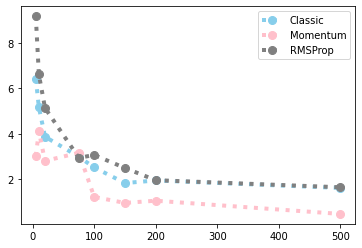

In [95]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

Widzimy, że najszybciej zbiega Momentum, a RMSProp i klasyczna propagacja wsteczna radzą sobie podobnie

## Zbiór Square Large

In [110]:
train_df = pd.read_csv('mio_data/regression/square-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/square-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.2, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.75, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

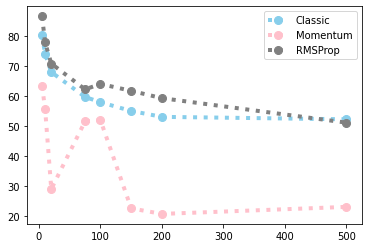

In [112]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

Wnioski jak w zbiorze pierwszym, możemy zobaczyć, że Momentum poradziło sobie najlepiej, mimo że około 100 iteracji trochę "zbłądziło".

## Zbiór Multimodal Large

In [114]:
train_df = pd.read_csv('mio_data/regression/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('mio_data/regression/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)
y_test = np.asarray(test_df['y']).reshape(-1, 1)

results_classic = []
results_momentum = []
results_rmsprop = []

for iterations in iterations_set:
    for _ in range (2):
        results_classic_temp = []
        results_momentum_temp = []
        results_rmsprop_temp = []

        mlp_classic = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_classic.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.001, method = "Classic")
        results_classic_temp.append(mean_absolute_error(y_test, mlp_classic.forward(x_test)))

        mlp_momentum = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_momentum.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.8, method = "Momentum")
        results_momentum_temp.append(mean_absolute_error(y_test, mlp_momentum.forward(x_test)))

        mlp_rmsprop = MLP(
        layers = layers, 
        weights_biases = "Random",
        activation_function = sigmoid,
        activation_function_der = sigmoid_der)

        mlp_rmsprop.learn(x, y, iterations=iterations, batch_size = 20, alpha=0.01, var=0.7, method = "RMSProp")
        results_rmsprop_temp.append(mean_absolute_error(y_test, mlp_rmsprop.forward(x_test)))
    
    results_classic.append(np.mean(results_classic_temp))
    results_momentum.append(np.mean(results_momentum_temp))
    results_rmsprop.append(np.mean(results_rmsprop_temp))

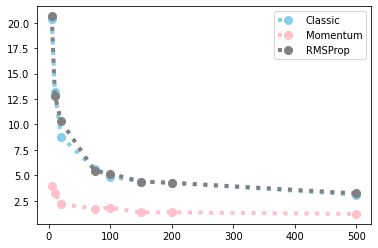

In [115]:
df=pd.DataFrame({'x_values': iterations_set, 'Classic': results_classic, 'Momentum': results_momentum, 'RMSProp': results_rmsprop })
plt.plot( 'x_values', 'Classic', data=df, marker='o', markerfacecolor='skyblue', markersize=8, color='skyblue', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'Momentum', data=df, marker='o', markerfacecolor='pink', markersize=8, color='pink', linewidth=4, linestyle='dotted')
plt.plot( 'x_values', 'RMSProp', data=df, marker='o', markerfacecolor='grey', markersize=8, color='grey', linewidth=4, linestyle='dotted')
plt.legend()

Wnioski jak w pierwszym zbiorze (są niemal identyczne)